# Building a Code-Executing Agent with LangGraph

### Overview
This notebook demonstrates how to build a reliable **Agentic Workflow** capable of executing Python code to solve complex queries. By equipping a Large Language Model (LLM) with a Python REPL tool, we enable it to perform precise mathematical calculations and data manipulation, overcoming the limitations of standard text prediction.

### Key Objectives
* **Orchestration:** Use `LangGraph` to manage the state and cyclic flow between the agent and the tools.
* **Tool Integration:** Implement `PythonREPLTool` via `LangChain` to allow the agent to execute arbitrary Python code.
* **Deterministic Logic:** Define a structured graph (Nodes & Edges) to handle the decision-making process (thinking vs. acting).



In [10]:
%pip install --quiet -U langgraph
%pip install --quiet -U langchain
%pip install --quiet -U langchain-openai
%pip install --quiet -U langchain-experimental

In [11]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)


def read_api(file_path: str) -> str:
  '''
  Read and Return OpenAI API from Drive.
  '''
  with open(file_path, 'r', encoding = 'utf-8-sig') as file:
    api_key = file.read().strip()
    return api_key


DRIVE_PATH = '/content/drive/MyDrive/api_key.txt'
api_key = read_api(file_path = DRIVE_PATH)

print(api_key is not None)
os.environ['OPENAI_API_KEY'] = api_key
print("OpenAI API key loaded:", os.environ.get('OPENAI_API_KEY') is not None)

Mounted at /content/drive
True
OpenAI API key loaded: True


In [12]:
from typing import Annotated, Literal, TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langchain_experimental.tools import PythonREPLTool

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

### Tools Configuration

Set up the Python REPL tool (which allows the AI to run Python code) and bind it to the LLM so the model knows it exists.

In [13]:
python_rpl = PythonREPLTool()
tools: list = [python_rpl]
tool_node = ToolNode(tools = tools)
llm_with_tools = llm.bind_tools(tools = tools)

### Define State and Agent Logic
Define the structure of the graph state (messages), set the System Message to instruct the agent on how to use the Python shell (e.g., forcing it to `print()` results), and create the main agent node function.

In [14]:
class State(TypedDict):
  '''
  Define the STATE
  '''
  messages: Annotated[list, add_messages]

system_msg = SystemMessage(content = """You are a Python coding assistant.
                                    IMPORTANT: You are executing code in a standard Python shell, NOT a notebook.
                                    You cannot verify the result if you do not print it.

                                    Rules:
                                    1. Do not just write the variable name at the end.
                                    2. You MUST wrap the final result in print().

                                    Example of BAD behavior:
                                    x = 10 + 5
                                    x

                                    Example of GOOD behavior:
                                    x = 10 + 5
                                    print(x) """)

def answer(state: State) -> State:
    msg = [system_msg] + state['messages']
    llm_response = llm_with_tools.invoke(msg)
    return {'messages': [llm_response]}

### Build the Graph
Construct the StateGraph by adding nodes and edges. This defines the flow: Agent -> (Decision) -> Tool or End. Finally, compile and display the graph structure.

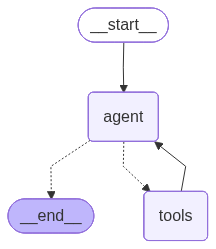

In [15]:
from IPython.display import Image, display

builder = StateGraph(State)

# NODES
builder.add_node("agent", answer)
builder.add_node("tools", tool_node)

# EDGES
builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", tools_condition)   # if agent return tool_call -> go to 'tools' else go to 'end'
builder.add_edge("tools", "agent")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### Run the Agent
Invoke the graph with a specific user query involving a mathematical calculation to test if the agent correctly utilizes the Python tool.

In [16]:
msg = graph.invoke({'messages': [HumanMessage(content = 'I took out a loan of $10,000 over 3 years with an interest rate of 4%. How much will I repay at the end?')]})

In [17]:
print(msg['messages'][-1].content)

You will repay a total of $11,200 at the end of the loan period.


In [18]:
# Python Code Output -- From tool_calls
print(msg['messages'][1].tool_calls[0]['args']['query'])

principal = 10000
rate = 0.04
time = 3
amount_repaid = principal * (1 + rate * time)
print(amount_repaid)
